In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from math import pi
import plancklens
from plancklens import utils, n0s
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp
import matplotlib as mpl
from math import pi
from orphics import maps, cosmology
mpl.rcParams['font.size']=12

In [2]:
exps_config = {
    'CMB_S3': {
        'nlev_t': 7,
        'nlev_p':7*2**0.5,j
        'beam_arcmin': 1.4,
        'result_nums': [0, 20, 40, 60, 80]
    },
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4,
        'result_nums': [90, 110, 130, 150, 170]
    }
}

In [3]:
A_cb = 1e-07
experiment = 'CMB_S4'

lmax = 3000
ellmin = 30
ellmax = 3000
Lmax = 3000

ls = np.arange(lmax+1)
ells = np.arange(ellmax+1)
fac_ls = ls*(ls+1)/(2*pi)

In [4]:
theory = cosmology.default_theory()
cltt, clee, clbb = theory.lCl('TT', ls), theory.lCl('EE', ls), theory.lCl('BB', ls)
clte = theory.lCl('TE', ls)

In [5]:
main_path = '/home/hongbo/projects/lens_rot_bias/'
cls_path = '/home/hongbo/projects/lens_rot_bias/inputPs'
claa = np.loadtxt(cls_path + '/claa_A%s.txt' %A_cb)[:,1]

In [6]:
# ns = [1.0, 0.95, 0.9]
ns = [1.05, 1.1]
claa_1 = A_cb/((ls[1:]*(ls[1:]+1))/(2*pi))
claa_095 = A_cb/(((ls[1:]*(ls[1:]+1))**(0.95)/(2*pi)))
claa_090 = A_cb/(((ls[1:]*(ls[1:]+1))**(0.9)/(2*pi)))
claa_105 = A_cb/(((ls[1:]*(ls[1:]+1))**(1.05)/(2*pi)))
claa_110 = A_cb/(((ls[1:]*(ls[1:]+1))**(1.1)/(2*pi)))

claa_1 = np.concatenate(([0], claa_1))
claa_095 = np.concatenate(([0], claa_095))
claa_090 = np.concatenate(([0], claa_090))
claa_105 = np.concatenate(([0], claa_105))
claa_110 = np.concatenate(([0], claa_110))

# np.save('../output/N1aa_plancklens/claa_1.dat', claa_1)
# np.save('../output/N1aa_plancklens/claa_0.95.dat', claa_095)
# np.save('../output/N1aa_plancklens/claa_0.90.dat', claa_090)

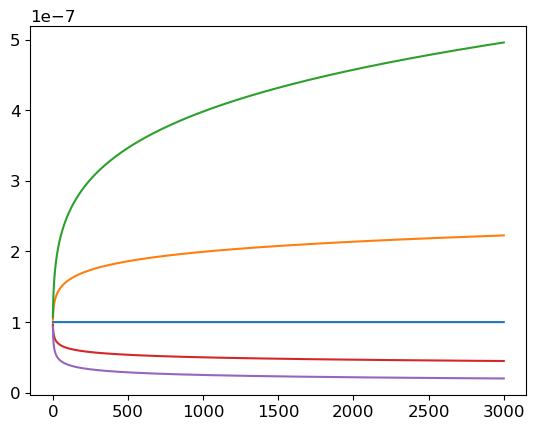

In [7]:
# blue claa power spectra
plt.plot(ls[1:], (ls*(ls+1)/(2*pi)*claa_1)[1:])
plt.plot(ls[1:], (ls*(ls+1)/(2*pi)*claa_095)[1:])
plt.plot(ls[1:], (ls*(ls+1)/(2*pi)*claa_090)[1:])
plt.plot(ls[1:], (ls*(ls+1)/(2*pi)*claa_105)[1:])
plt.plot(ls[1:], (ls*(ls+1)/(2*pi)*claa_110)[1:])

In [8]:
clpp = np.loadtxt(cls_path + '/cosmo2017_10K_acc3_lenspotentialCls.dat', \
                  usecols=(5), unpack=True)
fac = (ls*(ls+1))**2/(2*pi)
fac[0] = 1
clpp = np.concatenate(([1,1], clpp))[ls]/fac
clpp[0], clpp[1] = 0, 0

# np.savetxt('../output/N1aa_plancklens/clpp.dat', clpp)

In [9]:
nltt = (exps_config[experiment]['nlev_t']*\
        pi/180/60)**2/maps.gauss_beam(ls, exps_config[experiment]['beam_arcmin'])**2
nlee = (exps_config[experiment]['nlev_p']*\
        pi/180/60)**2/maps.gauss_beam(ls, exps_config[experiment]['beam_arcmin'])**2
nlbb = nlee

ocltt = cltt + nltt
oclee = clee + nlee
oclbb = clbb + nlbb
oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

In [10]:
ftl = 1/ocltt[:lmax+1]
fel = 1/oclee[:lmax+1]
fbl = 1/oclbb[:lmax+1]

# ftl[:ellmin] *= 0.
# fel[:ellmin] *= 0.
# fbl[:ellmin] *= 0.

ftl[:2] *= 0.
fel[:2] *= 0.
fbl[:2] *= 0.

In [11]:
n1aa_integral = []

for result_num in exps_config[experiment]['result_nums']:
    n1aa_integral.append(np.loadtxt(main_path+'/output/N1aa/N1aa_%s_%s_%s_30_3000.dat' \
                                    %(result_num, A_cb, experiment)))

n1aa_integral = np.array(n1aa_integral)
n1aa_sim = np.mean(n1aa_integral, axis=0)

In [12]:
#---- N1 lensing bias library:
if 0:
    n1_dd = n1.library_n1(main_path+'/N1aa_notebooks/N1aa_db/',cltt,clte,clee)
    n1aa = n1_dd.get_n1('peb', 'r', claa_110, ftl, fel, fbl, 3000)

In [13]:
cls_weights = {'tt':cltt,'ee':clee, 'bb':clbb,'te':clte}
cls_ivfs = {'tt':ftl, 'ee': fel, 'bb':fbl}
R = qresp.get_response('p_eb', 3000, 'p', cls_weights, cls_weights, cls_ivfs)[0][:3001]

In [14]:
R_tt = qresp.get_response('ptt', 3000, 'p', cls_weights, cls_weights, cls_ivfs)[0][:3001]

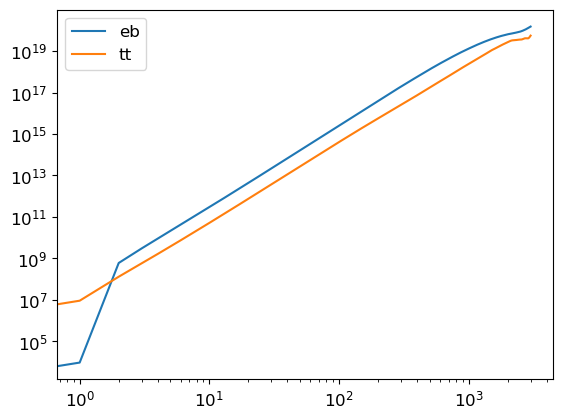

In [22]:
plt.plot(R, label='eb')
plt.plot(R_tt, label='tt')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [118]:
# np.savetxt('../output/N1aa_plancklens/R_%s_%s_%s.dat'%(experiment,ellmin, ellmax), R)

In [21]:
# n1aa_plancklens = np.concatenate(([0,0],2.5*(1/R[2:]**2)*n1aa[2:]))
np.savetxt('../output/N1aa_plancklens/N1aa_1.10_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat', \
           np.concatenate(([0,0],2.5*(1/R[2:]**2)*n1aa[2:])))

In [22]:
n1aa_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')
n1aa_1_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_1_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')
n1aa_095_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_0.95_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')
n1aa_090_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_0.90_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')
n1aa_105_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_1.05_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')
n1aa_110_plancklens = np.loadtxt('../output/N1aa_plancklens/N1aa_1.10_2.5plancklens_%s_%s_%s_%s'%(A_cb, experiment, ellmin, ellmax)+'.dat')

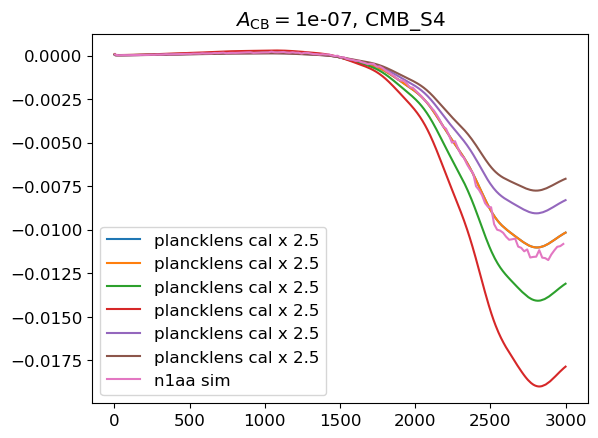

In [23]:
Ls = np.arange(5, ellmax+1, 20)
clpp[2:]
plt.plot(ls[2:], n1aa_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(ls[2:], n1aa_1_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(ls[2:], n1aa_095_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(ls[2:], n1aa_090_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(ls[2:], n1aa_105_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(ls[2:], n1aa_110_plancklens[2:]/clpp[2:], label='plancklens cal x 2.5')
plt.plot(Ls, n1aa_sim[Ls]/clpp[Ls], label='n1aa sim')
plt.title(r"$A_{\rm CB}=$%s, %s"%(A_cb, experiment))
plt.legend()